# Hypothese 1

max_depth x learning rate: Tiefere Bäume brauchen niedrige Lernraten um nicht zu overfitten

Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Original Training Set: (13275, 22)
Oversampled Training Set: (21810, 22)
Class distribution after oversampling: [7270 7270 7270]
Teste 36 Parameterkombinationen
[ 1/36] max_depth=5, lr=0.500 → F1: 0.7462 | Gap: 0.1953
[ 2/36] max_depth=5, lr=0.400 → F1: 0.7297 | Gap: 0.1696
[ 3/36] max_depth=5, lr=0.300 → F1: 0.7036 | Gap: 0.1388
[ 4/36] max_depth=5, lr=0.200 → F1: 0.6759 | Gap: 0.0997
[ 5/36] max_depth=5, lr=0.100 → F1: 0.6293 | Gap: 0.0612
[ 6/36] max_depth=5, lr=0.050 → F1: 0.5883 | Gap: 0.0359
[ 7/36] max_depth=7, lr=0.500 → F1: 0.8231 | Gap: 0.3167
[ 8/36] max_depth=7, lr=0.400 → F1: 0.8114 | Gap: 0.2845
[ 9/36] max_depth=7, lr=0.300 → F1: 0.7986 | Gap: 0.2451
[10/36] max_depth=7, lr=0.200 → F1: 0.7671 | Gap: 0.1949
[11/36] max_depth=7, lr=0.100 → F1: 0.7143 | Gap: 0.1307
[12/36] max_depth=7, lr=0.050 → F1: 0.6635 | Gap: 0.0866
[13/36] max_depth=9, lr=0.500 → F1: 0.8421 | Gap: 0.3780
[14/36] max_depth=9, lr=0.400 

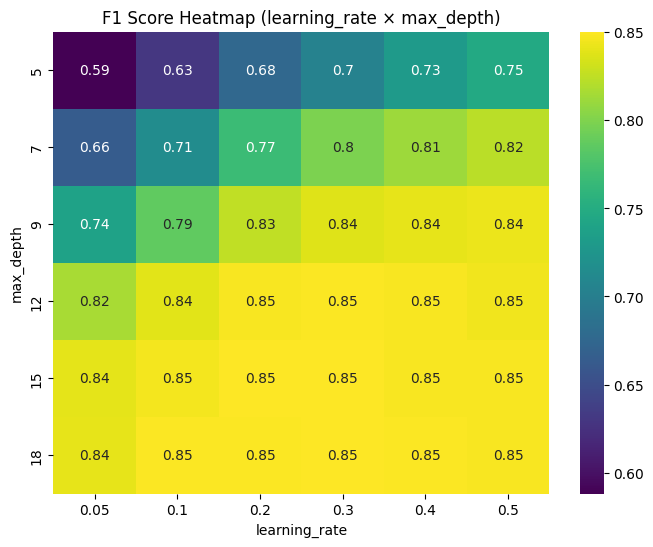

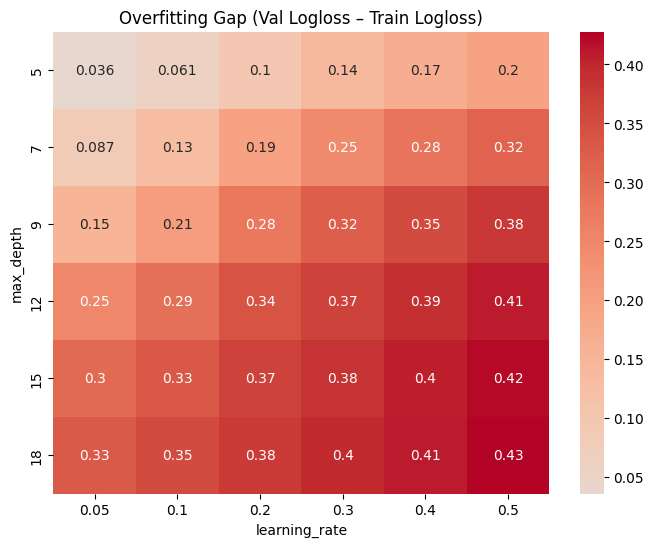


Top 5 Kombinationen nach F1:
    max_depth  learning_rate   f1_mean    f1_std  train_logloss  val_logloss  \
26         15            0.3  0.850196  0.001890       0.013803     0.397417   
27         15            0.2  0.850055  0.001606       0.024658     0.389954   
32         18            0.3  0.849483  0.001426       0.009980     0.405136   
33         18            0.2  0.848730  0.003730       0.016342     0.392340   
20         12            0.3  0.848729  0.001887       0.028555     0.394607   

    overfit_gap  
26     0.383614  
27     0.365296  
32     0.395156  
33     0.375998  
20     0.366052  


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings, time
warnings.filterwarnings('ignore')

# === 0. Daten laden ===
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

# === 1. Labels von 5 → 3 Klassen mappen ===
def map_labels(x):
    if x == 0:
        return 0   # sehr schnell adoptiert
    elif x == 4:
        return 2   # gar nicht adoptiert
    else:
        return 1   # mittlere Geschwindigkeiten (1,2,3)

df['target'] = df['AdoptionSpeed'].map(map_labels)

# === 2. Features & Labels trennen ===
X = df.drop(columns=['AdoptionSpeed', 'target'])
y = df['target'].astype(int)

# === 3. Stratified Split: Train / Temp ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Stratified Split: Temp → Valid / Test ===
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train classes:", np.unique(y_train))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# === 5. Kategorische Variablen in Kategorie-Typ umwandeln ===
for df_ in [X_train, X_valid, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# === 6. Oversampling nur auf Train ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape}")
print(f"Oversampled Training Set: {X_train_res.shape}")
print(f"Class distribution after oversampling: {np.bincount(y_train_res)}")

# === 7. Kategorische Spalten encodieren (OrdinalEncoder) ===
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    X_test[cat_cols]  = oe.transform(X_test[cat_cols])

# === 8. Parameter-Grid (nur 2 Parameter) ===
param_grid = {
    'max_depth': [5, 7, 9, 12, 15, 18],
    'learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
}
total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate'])
print(f"Teste {total_combinations} Parameterkombinationen")

# === 9. Evaluierungsfunktion inkl. Logloss ===
def evaluate_params_native(max_depth, learning_rate, X_data, y_data):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, train_loglosses, val_loglosses, gaps = [], [], [], []
    
    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval   = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softprob',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'eta': learning_rate,   # alias für learning_rate
            'seed': 42,
        }
        
        evals_result = {}
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            evals=[(dtrain, "train"), (dval, "val")],
            evals_result=evals_result,
            verbose_eval=False
        )
        
        preds = np.argmax(model.predict(dval), axis=1)
        f1 = f1_score(y_val, preds, average='weighted')
        f1_scores.append(f1)
        
        # Logloss Werte (letzter Schritt)
        train_ll = evals_result["train"]["mlogloss"][-1]
        val_ll   = evals_result["val"]["mlogloss"][-1]
        train_loglosses.append(train_ll)
        val_loglosses.append(val_ll)
        gaps.append(val_ll - train_ll)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'train_logloss': np.mean(train_loglosses),
        'val_logloss': np.mean(val_loglosses),
        'overfit_gap': np.mean(gaps)
    }

# === 10. Cross-Validation Grid Search ===
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

start_time = time.time()
results = []

for i, (md, lr) in enumerate(product(param_grid['max_depth'], param_grid['learning_rate']), 1):
    print(f"[{i:2d}/{total_combinations}] max_depth={md}, lr={lr:.3f}", end=" ")
    result = evaluate_params_native(md, lr, X_train_val, y_train_val)
    results.append(result)
    print(f"→ F1: {result['f1_mean']:.4f} | Gap: {result['overfit_gap']:.4f}")

print(f"\nGrid Search abgeschlossen in {(time.time()-start_time)/60:.1f} Minuten")

# === 11. Ergebnisse analysieren ===
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print("\nBestes Ergebnis:")
print(best_result)

# Heatmap F1
pivot_f1 = results_df.pivot(index="max_depth", columns="learning_rate", values="f1_mean")
plt.figure(figsize=(8,6))
sns.heatmap(pivot_f1, annot=True, cmap="viridis")
plt.title("F1 Score Heatmap (learning_rate × max_depth)")
plt.show()

# Heatmap Overfitting Gap
pivot_gap = results_df.pivot(index="max_depth", columns="learning_rate", values="overfit_gap")
plt.figure(figsize=(8,6))
sns.heatmap(pivot_gap, annot=True, cmap="coolwarm", center=0)
plt.title("Overfitting Gap (Val Logloss – Train Logloss)")
plt.show()

# Top 5
print("\nTop 5 Kombinationen nach F1:")
print(results_df.nlargest(5, "f1_mean"))


# Fazit 

### Hypothese bestätigt: Bei tieferen Bäumen ist der Overfit deutlich stärker bei höheren Lernraten also 0,3 0,4 oder 0,5 als bei niederigen wie 0,1 und 0,05. Zudem sieht man, dass die Performance generell steigt bei tieferen Bäumen, bis so 12-15 erreicht ist.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Hypothese 2

learning rate x n_estimators: Niedrige Lernraten erfordern deutlich mehr Bäume, um vergleichbare Performance zu haben. 

Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Original Training Set: (13275, 22)
Oversampled Training Set: (21810, 22)
Class distribution after oversampling: [7270 7270 7270]
Teste 35 Parameterkombinationen
[ 1/35] lr=0.300, n_estimators=200 → F1: 0.8075 | Gap: 0.2708
[ 2/35] lr=0.200, n_estimators=200 → F1: 0.7809 | Gap: 0.2208
[ 3/35] lr=0.100, n_estimators=200 → F1: 0.7216 | Gap: 0.1427
[ 4/35] lr=0.050, n_estimators=200 → F1: 0.6696 | Gap: 0.0906
[ 5/35] lr=0.030, n_estimators=200 → F1: 0.6388 | Gap: 0.0658
[ 6/35] lr=0.010, n_estimators=200 → F1: 0.5783 | Gap: 0.0286
[ 7/35] lr=0.005, n_estimators=200 → F1: 0.5593 | Gap: 0.0157
[ 8/35] lr=0.300, n_estimators=300 → F1: 0.8282 | Gap: 0.3189
[ 9/35] lr=0.200, n_estimators=300 → F1: 0.8083 | Gap: 0.2673
[10/35] lr=0.100, n_estimators=300 → F1: 0.7575 | Gap: 0.1835
[11/35] lr=0.050, n_estimators=300 → F1: 0.6987 | Gap: 0.1164
[12/35] lr=0.030, n_estimators=300 → F1: 0.6660 | Gap: 0.0856
[13/35] lr=0.010, n_estimat

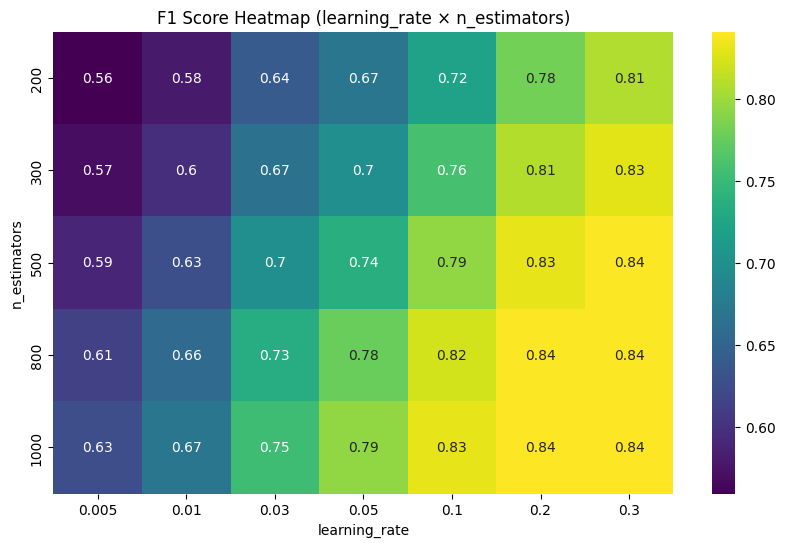

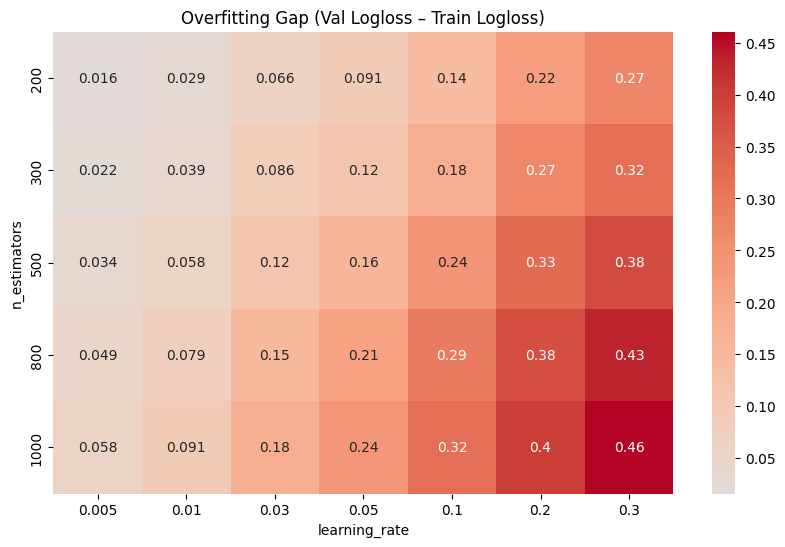


Top 5 Kombinationen nach F1:
    n_estimators  learning_rate   f1_mean    f1_std  train_logloss  \
29          1000            0.2  0.840976  0.003537       0.039005   
28          1000            0.3  0.840641  0.003501       0.014720   
21           800            0.3  0.839424  0.003907       0.024022   
14           500            0.3  0.839103  0.002993       0.066632   
22           800            0.2  0.838846  0.003796       0.063408   

    val_logloss  overfit_gap  
29     0.441753     0.402748  
28     0.475534     0.460814  
21     0.458426     0.434404  
14     0.444353     0.377721  
22     0.440643     0.377235  


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings, time
warnings.filterwarnings('ignore')

# === 0. Daten laden ===
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

# === 1. Labels von 5 → 3 Klassen mappen ===
def map_labels(x):
    if x == 0:
        return 0   # sehr schnell adoptiert
    elif x == 4:
        return 2   # gar nicht adoptiert
    else:
        return 1   # mittlere Geschwindigkeiten (1,2,3)

df['target'] = df['AdoptionSpeed'].map(map_labels)

# === 2. Features & Labels trennen ===
X = df.drop(columns=['AdoptionSpeed', 'target'])
y = df['target'].astype(int)

# === 3. Stratified Split: Train / Temp ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Stratified Split: Temp → Valid / Test ===
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train classes:", np.unique(y_train))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# === 5. Kategorische Variablen in Kategorie-Typ umwandeln ===
for df_ in [X_train, X_valid, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# === 6. Oversampling nur auf Train ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape}")
print(f"Oversampled Training Set: {X_train_res.shape}")
print(f"Class distribution after oversampling: {np.bincount(y_train_res)}")

# === 7. Kategorische Spalten encodieren (OrdinalEncoder) ===
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    X_test[cat_cols]  = oe.transform(X_test[cat_cols])

# === 8. Parameter-Grid (n_estimators × learning_rate) ===
param_grid = {
    'n_estimators': [200, 300, 500, 800, 1000],
    'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.03, 0.01, 0.005]
}
total_combinations = len(param_grid['n_estimators']) * len(param_grid['learning_rate'])
print(f"Teste {total_combinations} Parameterkombinationen")

# === 9. Evaluierungsfunktion inkl. Logloss ===
def evaluate_params_native(n_estimators, learning_rate, X_data, y_data):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, train_loglosses, val_loglosses, gaps = [], [], [], []
    
    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval   = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softprob',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'eta': learning_rate,
            'max_depth': 6,     # fixiert für Hypothese
            'subsample': 1.0,
            'seed': 42,
        }
        
        evals_result = {}
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=n_estimators,  # hier wichtig!
            evals=[(dtrain, "train"), (dval, "val")],
            evals_result=evals_result,
            verbose_eval=False
        )
        
        preds = np.argmax(model.predict(dval), axis=1)
        f1 = f1_score(y_val, preds, average='weighted')
        f1_scores.append(f1)
        
        # Logloss Werte (letzter Schritt)
        train_ll = evals_result["train"]["mlogloss"][-1]
        val_ll   = evals_result["val"]["mlogloss"][-1]
        train_loglosses.append(train_ll)
        val_loglosses.append(val_ll)
        gaps.append(val_ll - train_ll)
    
    return {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'train_logloss': np.mean(train_loglosses),
        'val_logloss': np.mean(val_loglosses),
        'overfit_gap': np.mean(gaps)
    }

# === 10. Cross-Validation Grid Search ===
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

start_time = time.time()
results = []

for i, (n_est, lr) in enumerate(product(param_grid['n_estimators'], param_grid['learning_rate']), 1):
    print(f"[{i:2d}/{total_combinations}] lr={lr:.3f}, n_estimators={n_est}", end=" ")
    result = evaluate_params_native(n_est, lr, X_train_val, y_train_val)
    results.append(result)
    print(f"→ F1: {result['f1_mean']:.4f} | Gap: {result['overfit_gap']:.4f}")

print(f"\nGrid Search abgeschlossen in {(time.time()-start_time)/60:.1f} Minuten")

# === 11. Ergebnisse analysieren ===
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print("\nBestes Ergebnis:")
print(best_result)

# Heatmap F1
pivot_f1 = results_df.pivot(index="n_estimators", columns="learning_rate", values="f1_mean")
plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, cmap="viridis")
plt.title("F1 Score Heatmap (learning_rate × n_estimators)")
plt.show()

# Heatmap Overfitting Gap
pivot_gap = results_df.pivot(index="n_estimators", columns="learning_rate", values="overfit_gap")
plt.figure(figsize=(10,6))
sns.heatmap(pivot_gap, annot=True, cmap="coolwarm", center=0)
plt.title("Overfitting Gap (Val Logloss – Train Logloss)")
plt.show()

# Top 5
print("\nTop 5 Kombinationen nach F1:")
print(results_df.nlargest(5, "f1_mean"))


## Fazit

#### Hypothese bestätigt: Kleinere Lernraten benötigen definitv mehr n_estimators um mithalten zu können mit 0,3 und 0,2 etc.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Hypothese 3

max_depth x subsample: Hohe max_depth benötigen tiefe subsample Werte, während flache Bäume also niedrige max_depth von hohem subsample profitieren

Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Original Training Set: (13275, 22)
Oversampled Training Set: (21810, 22)
Class distribution after oversampling: [7270 7270 7270]
Teste 42 Parameterkombinationen
[ 1/42] max_depth=3, subsample=1.0 → F1: 0.6633 | Gap: 0.1034
[ 2/42] max_depth=3, subsample=0.9 → F1: 0.6667 | Gap: 0.1085
[ 3/42] max_depth=3, subsample=0.8 → F1: 0.6657 | Gap: 0.1114
[ 4/42] max_depth=3, subsample=0.7 → F1: 0.6663 | Gap: 0.1145
[ 5/42] max_depth=3, subsample=0.6 → F1: 0.6607 | Gap: 0.1132
[ 6/42] max_depth=3, subsample=0.5 → F1: 0.6625 | Gap: 0.1138
[ 7/42] max_depth=5, subsample=1.0 → F1: 0.7896 | Gap: 0.2557
[ 8/42] max_depth=5, subsample=0.9 → F1: 0.7995 | Gap: 0.2675
[ 9/42] max_depth=5, subsample=0.8 → F1: 0.8004 | Gap: 0.2747
[10/42] max_depth=5, subsample=0.7 → F1: 0.7978 | Gap: 0.2785
[11/42] max_depth=5, subsample=0.6 → F1: 0.7941 | Gap: 0.2825
[12/42] max_depth=5, subsample=0.5 → F1: 0.7899 | Gap: 0.2867
[13/42] max_depth=7, subsam

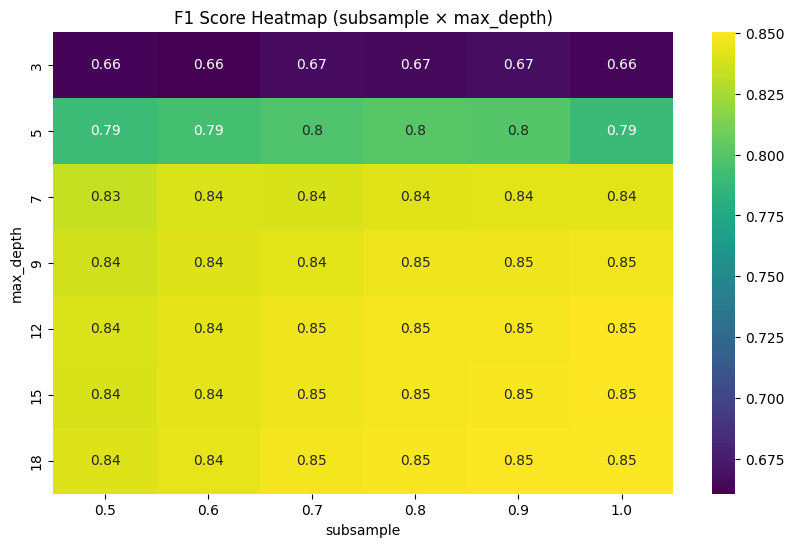

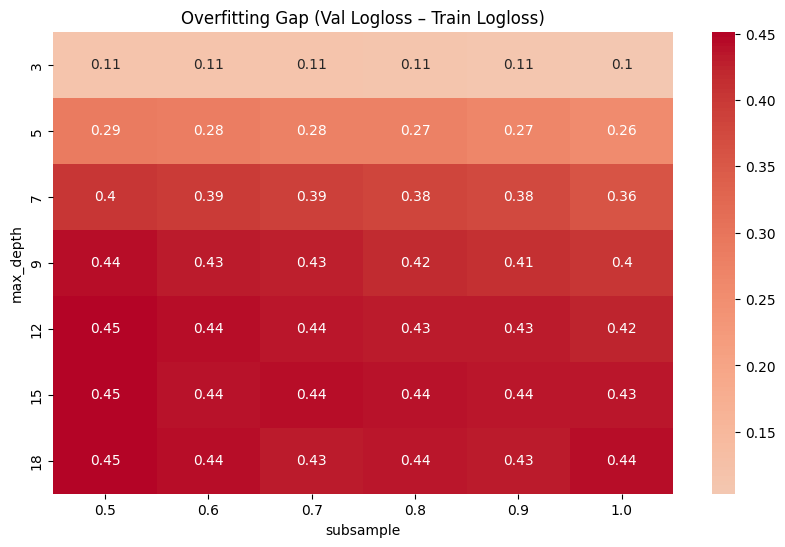


Top 5 Kombinationen nach F1:
    max_depth  subsample   f1_mean    f1_std  train_logloss  val_logloss  \
24         12        1.0  0.850504  0.001825       0.006001     0.430911   
30         15        1.0  0.849859  0.002150       0.004072     0.438057   
37         18        0.9  0.849622  0.004109       0.003516     0.436831   
36         18        1.0  0.849080  0.002314       0.003395     0.444424   
31         15        0.9  0.848518  0.003395       0.003955     0.439552   

    overfit_gap  
24     0.424910  
30     0.433985  
37     0.433315  
36     0.441029  
31     0.435598  


In [11]:
df = pd.read_csv("Data/preprocessed/combined_preprocessed.csv")

# === 1. Labels von 5 → 3 Klassen mappen ===
def map_labels(x):
    if x == 0:
        return 0   # sehr schnell adoptiert
    elif x == 4:
        return 2   # gar nicht adoptiert
    else:
        return 1   # mittlere Geschwindigkeiten (1,2,3)

df['target'] = df['AdoptionSpeed'].map(map_labels)

# === 2. Features & Ziel ===
X = df.drop(columns=['AdoptionSpeed', 'target'])
y = df['target'].astype(int)

# === 3. Stratified Split: Train / Temp ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Stratified Split: Temp → Valid / Test ===
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train classes:", np.unique(y_train))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# === 5. Kategorische Variablen in Kategorie-Typ umwandeln ===
for df_ in [X_train, X_valid, X_test]:
    for col in df_.select_dtypes(include=["object"]).columns:
        df_[col] = df_[col].astype("category")

# === 6. Oversampling nur auf Train ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(f"Original Training Set: {X_train.shape}")
print(f"Oversampled Training Set: {X_train_res.shape}")
print(f"Class distribution after oversampling: {np.bincount(y_train_res)}")

# === 7. Kategorische Spalten encodieren (OrdinalEncoder) ===
cat_cols = X_train_res.select_dtypes(include=["category"]).columns
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    X_train_res[cat_cols] = oe.fit_transform(X_train_res[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    X_test[cat_cols]  = oe.transform(X_test[cat_cols])

# === 8. Parameter-Grid (max_depth × subsample) ===
param_grid = {
    'max_depth': [3, 5, 7, 9, 12, 15, 18],
    'subsample': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
}
total_combinations = len(param_grid['max_depth']) * len(param_grid['subsample'])
print(f"Teste {total_combinations} Parameterkombinationen")

# === 9. Evaluierungsfunktion inkl. Logloss ===
def evaluate_params_native(max_depth, subsample, X_data, y_data):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, train_loglosses, val_loglosses, gaps = [], [], [], []
    
    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval   = xgb.DMatrix(X_val, label=y_val)
        
        params = {
            'objective': 'multi:softprob',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'max_depth': max_depth,
            'subsample': subsample,
            'seed': 42,
        }
        
        evals_result = {}
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=300,  # fixiert
            evals=[(dtrain, "train"), (dval, "val")],
            evals_result=evals_result,
            verbose_eval=False
        )
        
        preds = np.argmax(model.predict(dval), axis=1)
        f1 = f1_score(y_val, preds, average='weighted')
        f1_scores.append(f1)
        
        # Logloss Werte (letzter Schritt)
        train_ll = evals_result["train"]["mlogloss"][-1]
        val_ll   = evals_result["val"]["mlogloss"][-1]
        train_loglosses.append(train_ll)
        val_loglosses.append(val_ll)
        gaps.append(val_ll - train_ll)
    
    return {
        'max_depth': max_depth,
        'subsample': subsample,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'train_logloss': np.mean(train_loglosses),
        'val_logloss': np.mean(val_loglosses),
        'overfit_gap': np.mean(gaps)
    }

# === 10. Cross-Validation Grid Search ===
X_train_val = pd.concat([X_train_res, X_valid])
y_train_val = pd.concat([y_train_res, y_valid])

start_time = time.time()
results = []

for i, (md, sub) in enumerate(product(param_grid['max_depth'], param_grid['subsample']), 1):
    print(f"[{i:2d}/{total_combinations}] max_depth={md}, subsample={sub:.1f}", end=" ")
    result = evaluate_params_native(md, sub, X_train_val, y_train_val)
    results.append(result)
    print(f"→ F1: {result['f1_mean']:.4f} | Gap: {result['overfit_gap']:.4f}")

print(f"\nGrid Search abgeschlossen in {(time.time()-start_time)/60:.1f} Minuten")

# === 11. Ergebnisse analysieren ===
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['f1_mean'].idxmax()]
print("\nBestes Ergebnis:")
print(best_result)

# Heatmap F1
pivot_f1 = results_df.pivot(index="max_depth", columns="subsample", values="f1_mean")
plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, cmap="viridis")
plt.title("F1 Score Heatmap (subsample × max_depth)")
plt.show()

# Heatmap Overfitting Gap
pivot_gap = results_df.pivot(index="max_depth", columns="subsample", values="overfit_gap")
plt.figure(figsize=(10,6))
sns.heatmap(pivot_gap, annot=True, cmap="coolwarm", center=0)
plt.title("Overfitting Gap (Val Logloss – Train Logloss)")
plt.show()

# Top 5
print("\nTop 5 Kombinationen nach F1:")
print(results_df.nlargest(5, "f1_mean"))

## Fazit

#### Keine besondere Korrelation zu erkennen, Hypothese nicht bestätigt